In [18]:
%pylab inline
import matplotlib as mpl
import pandas as pd
from scipy import signal
from scipy.signal import get_window
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
from riboraptor.coherence import coherence
from riboraptor.plotting import plot_framewise_counts, plot_read_length_dist
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['font.size'] = 32
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['figure.figsize'] = (7.2,4.45)
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['axes.labelsize'] = 32
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['mathtext.fontset'] = 'stix'      
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['lines.linewidth'] = 3.5
mpl.rcParams['xtick.labelsize'] = 32
mpl.rcParams['ytick.labelsize'] = 32
mpl.rcParams['legend.fontsize'] = 32
AVAILABLE_WINDOWS = ['boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett', 
                     'flattop', 'parzen', 'bohman', 'blackmanharris', 'nuttall',
                     'barthann']

def setup_axis(ax):
    ax.set_xlabel('')
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(  AutoMinorLocator(5))
    ax.tick_params(direction='out', length=12, 
                   width=2, 
                   grid_alpha=0.5)
    ax.tick_params(direction='out', which='minor', length=6, 
                   width=1, 
                   grid_alpha=0.5)
    ax.grid(True)
    
def plot_windows(windows, Nx=4096):
    # boxcar, triang, blackman, hamming, hann, bartlett, 
    # flattop, parzen, bohman, blackmanharris, nuttall, 
    # barthann, 
    
    # kaiser (needs beta), 
    # gaussian (needs standard deviation), 
    # general_gaussian (needs power, width), 
    # slepian (needs width), 
    # dpss (needs normalized half-bandwidth), 
    # chebwin (needs attenuation), 
    # exponential (needs decay scale), 
    # tukey (needs taper fraction)
    if not isinstance(windows, tuple):
        windows = [windows]
    fig, ax = plt.subplots(figsize=(16, 12))
    for window in windows:
        gwindow = get_window(window, Nx=Nx)
        ax.plot(gwindow, label=window, linestyle='-.')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    setup_axis(ax)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    fig.tight_layout()

    
select = widgets.SelectMultiple(
    options=AVAILABLE_WINDOWS,
    value=('flattop',),
    disabled=False,
)
interact(plot_windows, windows=select, Nx=(1, 4097))


Populating the interactive namespace from numpy and matplotlib


/home/saket/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['select', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


interactive(children=(SelectMultiple(description='windows', index=(6,), options=('boxcar', 'triang', 'blackman…

<function __main__.plot_windows(windows, Nx=4096)>

In [2]:
colors = ['#a6cee3',
          '#1f78b4',
          '#b2df8a',
          '#33a02c',
          '#fb9a99',
          '#e31a1c',
          '#fdbf6f',
          '#ff7f00',
          '#cab2d6',
          '#6a3d9a',
          '#ffff99']
def plot_freq_mix(freq1, freq2, windows):
    if not isinstance(windows, tuple):
        windows = [windows]
    fig = plt.figure(figsize=(25, 20))
    ax = plt.subplot(211)
    t = np.arange(0, 60, step=1)
    s = np.sin( 2*t*np.pi*freq1) + np.sin( 2*t*np.pi*freq2)
    

    setup_axis(ax)
    ax.plot(t, s)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax = plt.subplot(212)
    for color, window in zip(colors, windows):
        n = 4096
        w = np.fft.rfft(s * get_window(window, 60), n=n)
        freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
        ax.plot(freqs, 20*np.log10(np.abs(w)), label=window, color=color)
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.)
    setup_axis(ax)
    ax.set_xlabel('Frequnecy (Hz)')
    ax.set_ylabel('decibels')

    fig.tight_layout()
interact(plot_freq_mix, 
         freq1=widgets.FloatSlider(min=0.1,max=30,step=0.01,value=0.33), 
         freq2=widgets.FloatSlider(min=0.1,max=30,step=0.01,value=0.33),
         windows=select,)


interactive(children=(FloatSlider(value=0.33, description='freq1', max=30.0, min=0.1, step=0.01), FloatSlider(…

<function __main__.plot_freq_mix(freq1, freq2, windows)>

In [ ]:
1996288 2915982 3643866 4192646 5692884 6306307 7890384 8430354 9090960 0030057

#  Effect of window v/s signal

In [3]:
def coherence(values,nperseg,noverlap,  window='flattop'):
    """Calculate coherence and an idea ribo-seq signal

    Parameters
    ----------
    values : array like
             List of values

    Returns
    -------
    periodicity : float
                  Periodicity score calculated as
                  coherence between input and idea 1-0-0 signal

    window: str or tuple
            See scipy.signal.get_window


    f: array like
       List of frequencies

    Cxy: array like
         List of coherence at the above frequencies

    """
    length = len(values)
    uniform_signal = [1, 0, 0] * (length // 3)
    mean_centered_values = values - np.nanmean(values)
    normalized_values = mean_centered_values / \
        np.max(np.abs(mean_centered_values))

    mean_centered_values = uniform_signal - np.nanmean(uniform_signal)
    uniform_signal = mean_centered_values / \
        np.max(np.abs(uniform_signal))
    f, Cxy = signal.coherence(normalized_values,
                              uniform_signal,
                              window=window,
                              nperseg=nperseg,
                              noverlap=noverlap)
    periodicity_score = Cxy[np.argwhere(np.isclose(f, 1 / 3.0))[0]][0]
    return periodicity_score, f, Cxy, normalized_values

def coherence_nonorm(values,nperseg,noverlap,  window='flattop'):
    """Calculate coherence and an idea ribo-seq signal

    Parameters
    ----------
    values : array like
             List of values

    Returns
    -------
    periodicity : float
                  Periodicity score calculated as
                  coherence between input and idea 1-0-0 signal

    window: str or tuple
            See scipy.signal.get_window


    f: array like
       List of frequencies

    Cxy: array like
         List of coherence at the above frequencies

    """
    length = len(values)
    uniform_signal = [1, 0, 0] * (length // 3)
    f, Cxy = signal.coherence(values,
                              uniform_signal,
                              window=window,
                              nperseg=nperseg,
                              noverlap=noverlap)
    periodicity_score = Cxy[np.argwhere(np.isclose(f, 1 / 3.0))[0]][0]
    return periodicity_score, f, Cxy

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


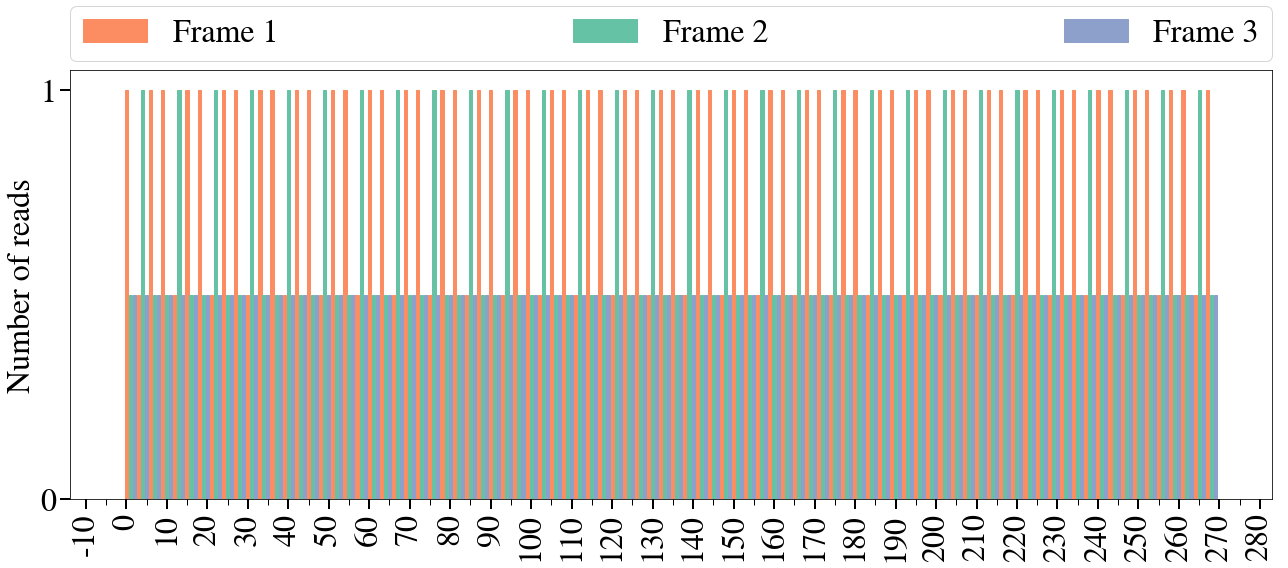

In [4]:
s = [1, 0.5, 0.5, 0.5, 1, 0.5, 1, 0.5, 0.5]*30
s1 = pd.Series(s)
fig, ax = plt.subplots(figsize=(18, 8))
plot_framewise_counts(s1, ax=ax, xrotation=90)
for i in ax.get_xticklabels():
    i.set_rotation(90)

In [5]:
s[6:9]

[1, 0.5, 0.5]

In [6]:
s = [1, 0.5, 0.5, 0.5, 1, 0.5, 1, 0.5, 0.5]*30
coherence(s[0:3]*30, 3,0)

(1.000000000000001,
 array([0.        , 0.33333333]),
 array([1., 1.]),
 array([ 1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5]))

In [7]:
coherence(s, 3,0)

(0.33333333333333387,
 array([0.        , 0.33333333]),
 array([0.33333333, 0.33333333]),
 array([ 1. , -0.5, -0.5, -0.5,  1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5, -0.5,  1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,
         1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,  1. , -0.5,
         1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,  1. , -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5, -0.5,  1. , -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5, -0.5,  1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
        -0.5,  1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,  1. ,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,  1. , -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5, -0.5,  1. , -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5, -0.5,  1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5, -0.5,  1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,
         1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,  1. , -0.5,
         1. , -0.5, -0

In [8]:
coherence(s*30, 30,0)

(0.9813304465625935,
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       ]),
 array([1.07420521e-30, 2.82333196e-31, 8.81877401e-31, 1.46297603e-31,
        5.82328208e-32, 9.18532995e-33, 4.62617671e-04, 6.38083084e-02,
        4.80715584e-01, 8.80657162e-01, 9.81330447e-01, 7.58595721e-01,
        2.82894518e-01, 2.81704213e-02, 1.83688061e-04, 0.00000000e+00]),
 array([ 1. , -0.5, -0.5, ...,  1. , -0.5, -0.5]))

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


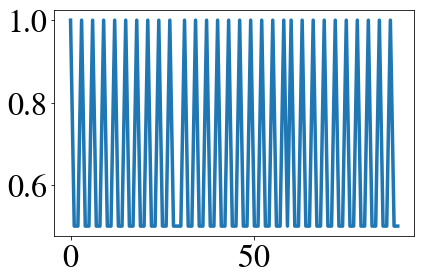

In [9]:
plt.plot(s[0:3]*10+s[3:6]*10+s[6:9]*10,)

In [10]:
coherence(s[0:3]*10+s[3:6]*10+s[6:9]*10, 15,14)

(0.2897939569126008,
 array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
        0.33333333, 0.4       , 0.46666667]),
 array([3.40858889e-34, 5.99027994e-03, 1.80581116e-01, 2.87563338e-01,
        2.99573072e-01, 2.89793957e-01, 2.89199348e-01, 2.15608529e-01]),
 array([ 1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5,  1. , -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5]))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


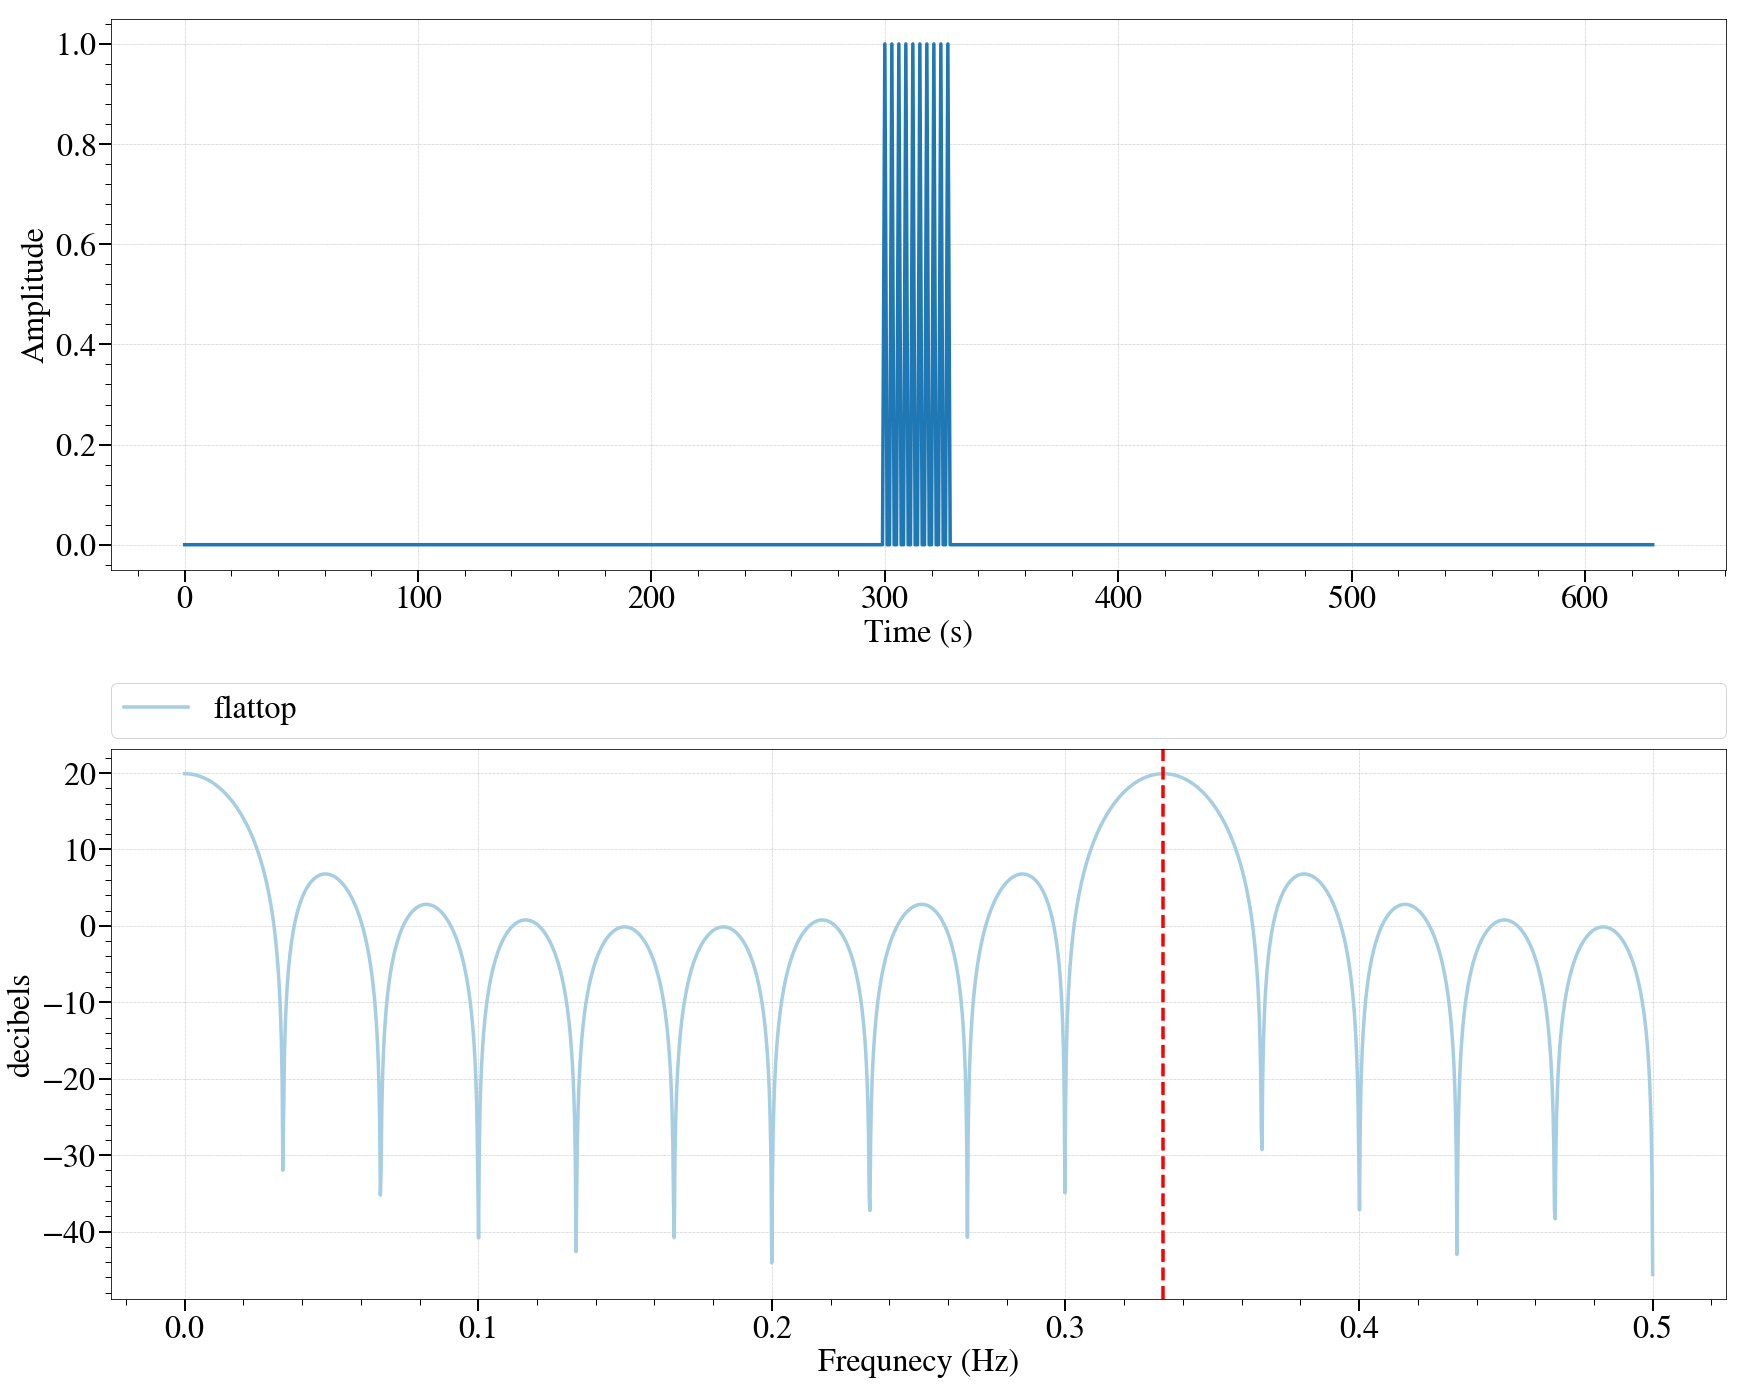

In [41]:
def plot_ft(s, windows):
    if isinstance(windows, str):
        windows = [windows]
    fig = plt.figure(figsize=(25, 20))
    ax = plt.subplot(211)
    t = np.arange(0, len(s), step=1)
    #s = signal#np.sin( 2*t*np.pi*freq1)# + np.sin( 2*t*np.pi*freq2)
    print(s)

    setup_axis(ax)
    ax.plot(t, s)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax = plt.subplot(212)
    for color, window in zip(colors, windows):
        n = 4096
        w = np.fft.rfft(s * get_window(window, len(s)), n=n)
        freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
        ax.plot(freqs, 20*np.log10(np.abs(w)), label=window, color=color)
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=3)
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.)
    setup_axis(ax)
    ax.set_xlabel('Frequnecy (Hz)')
    ax.set_ylabel('decibels')
    ax.axvline(1/3.0, color='red', linestyle='dashed')
    fig.tight_layout()

select = widgets.SelectMultiple(
    options=AVAILABLE_WINDOWS,
    value=('flattop',),
    disabled=False,
)
sig = [0]*300 + [1,0,0]*10 + [0]*300
plot_ft(sig,   windows='flattop')

[0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2, 0.1, 0.8, 0.2,

/home/saket/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


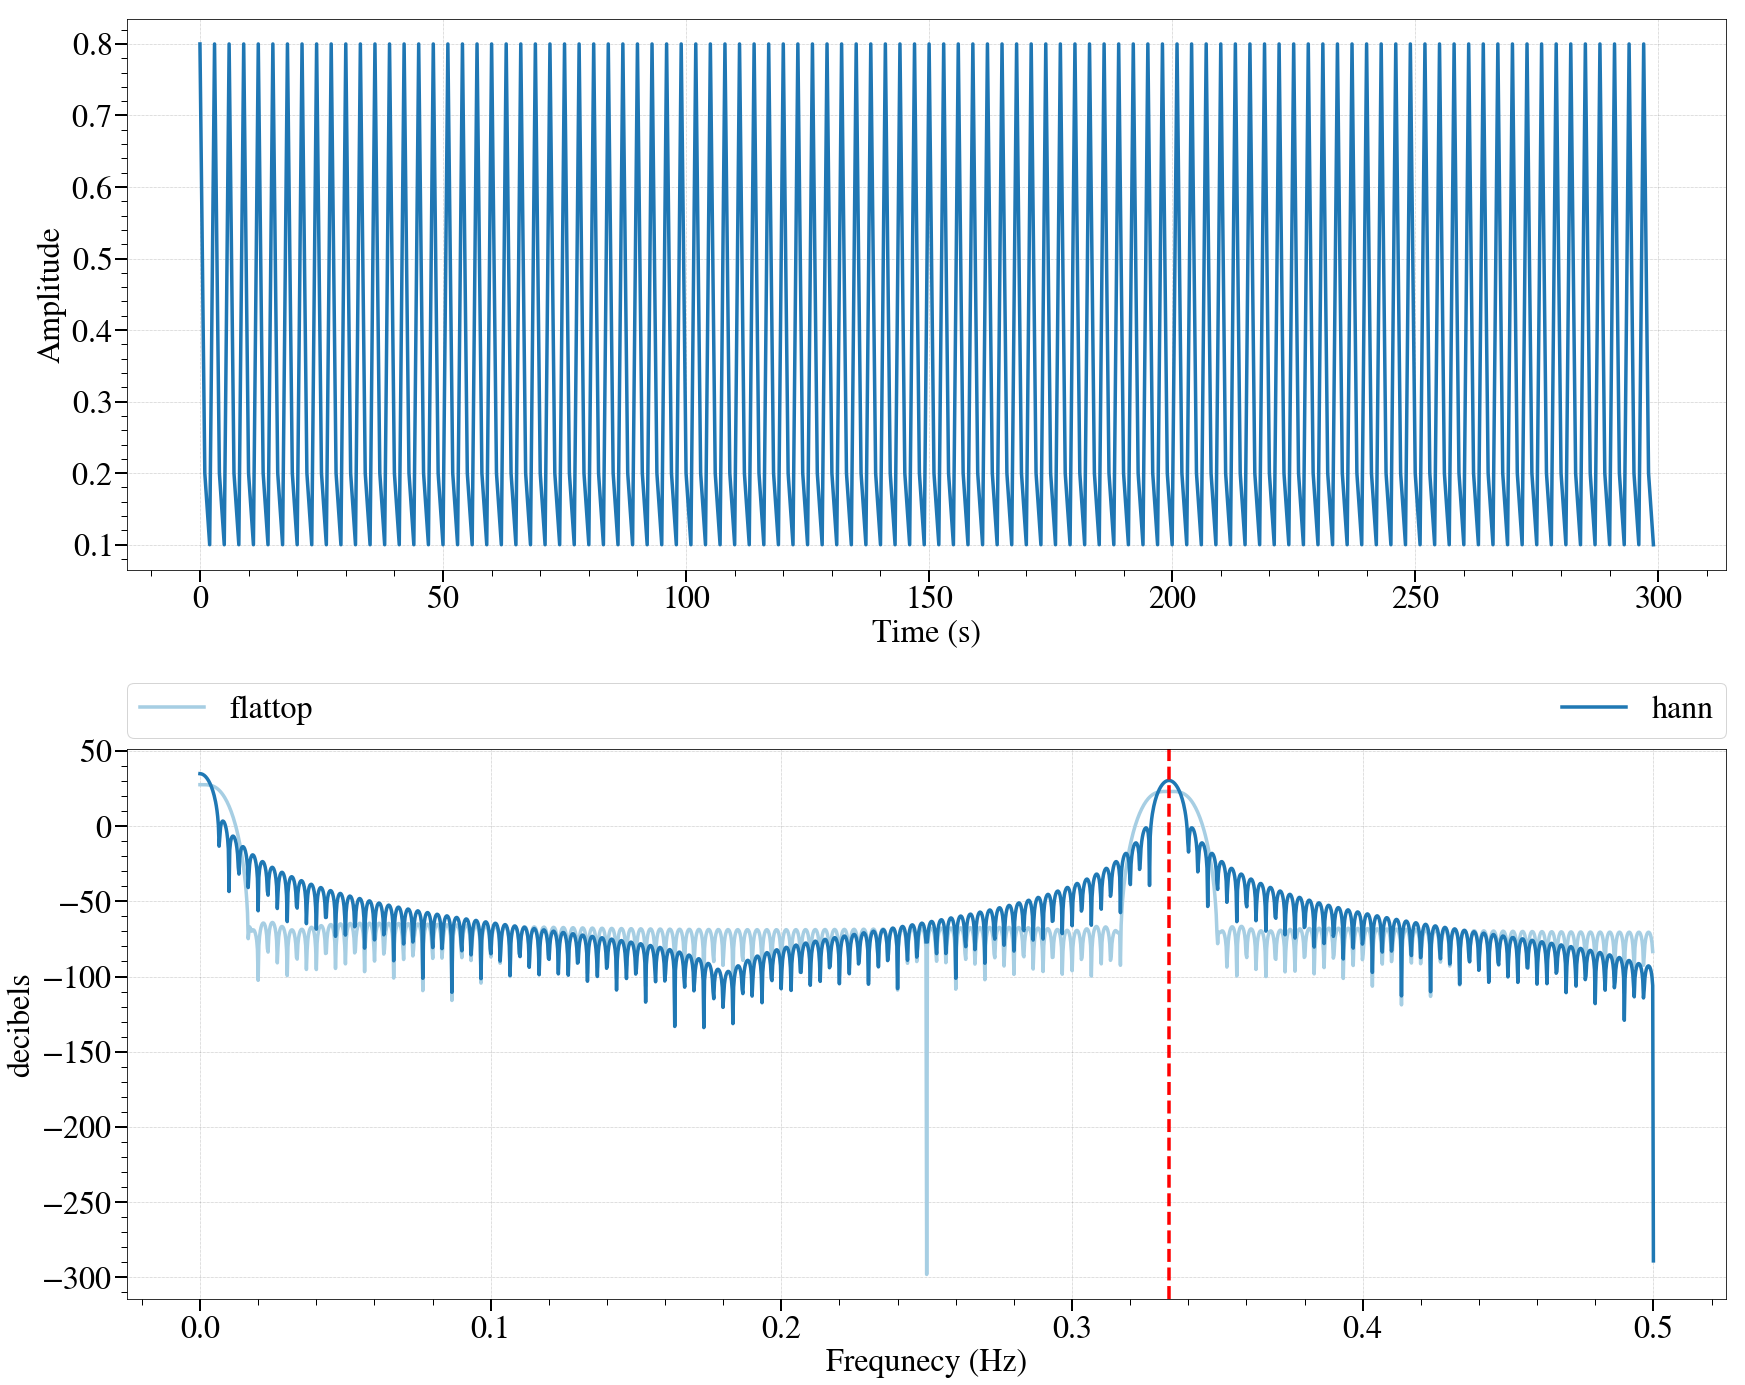

In [42]:
sig = [0.8,0.2,0.1]*100
plot_ft(sig,   windows=['flattop', 'hann'])

In [19]:
coherence(s[3:6]*30, 3,2)

(0.5160031906009611,
 array([0.        , 0.33333333]),
 array([0.25428571, 0.51600319]),
 array([-0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5]))

1-0-0 for window size of 3 is indedepend  of the overlap size

In [40]:
s = [0.8,0.2,0.1]
coherence_nonorm(s , 3, 0)[0]

1.0000000000000002

In [33]:
coherence(s[0:3] , 3, 0)[0]

0.9999999999999998

In [67]:
s = [1,1,0]*90
coherence(s , 90,0)[0]

/home/saket/anaconda3/lib/python3.6/site-packages/scipy/signal/spectral.py:1382: RuntimeWarning: invalid value encountered in true_divide
  Cxy = np.abs(Pxy)**2 / Pxx / Pyy


1.0000000000000002

In [34]:
coherence(s[0:3]*30, 3,2)[0]

0.9999999999999983

In [35]:
coherence(s[0:3]*30, 3, 1)[0]

0.9999999999999996

In [27]:
coherence(s[0:3]*30, 3, 0)[0]

1.000000000000001

0-1-0 for window size of 3 is not indepdend of the window size

In [31]:
s[3:6]

[0, 1, 0]

In [32]:
coherence(s[3:6] , 3, 0)[0]

1.0000000000000007

In [28]:
coherence(s[3:6] *30, 3, 0)[0]

0.9999999999999989

In [29]:
coherence(s[3:6] *30, 3, 1)[0]

0.5226824529751184

In [30]:
coherence(s[3:6] *30, 3, 2)[0]

0.5160031906009611

(1.0000000000000007,
 array([0.        , 0.33333333]),
 array([1., 1.]),
 array([-0.5,  1. , -0.5]))

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


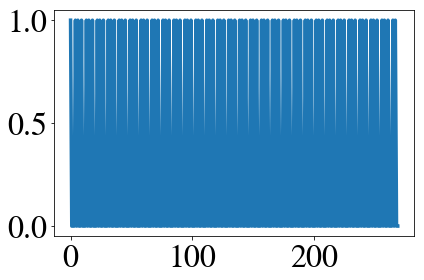

In [17]:
s = [1, 0, 0, 0, 1, 0, 1, 0,0]*30
plt.plot(s)
coherence(s[3:6], 3,0)

(0.5309546280999312,
 array([0.        , 0.33333333]),
 array([0.01818182, 0.53095463]),
 array([ 1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,
        -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5,  1. ,
        -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,  1. , -0.5, -0.5,
         1. , -0.5, -0.

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


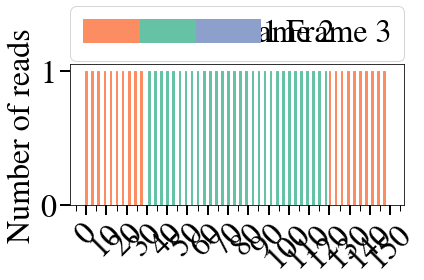

In [14]:
s = [1, 0, 0]*10 + [0, 1, 0,]*30 + [1, 0,0]*10
plot_framewise_counts(pd.Series(s))
coherence(s, 3,0)

In [32]:
# Load SRP098789
rna_sample = pd.read_table('/data1/hg38/SRP098789/metagene_coverages/SRX2536425.tsv')
rna_counts = pd.Series(rna_sample['count'].tolist(), index=rna_sample['position'].tolist())
ribo_sample = pd.read_table('/data1/hg38/SRP098789/metagene_coverages/SRX2536403.tsv')
ribo_counts = pd.Series(ribo_sample['count'].tolist(), index=ribo_sample['position'].tolist())


/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


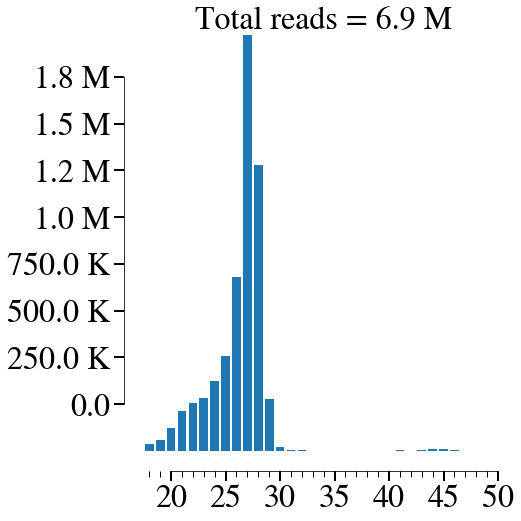

In [29]:
ribo_sample_read_len = pd.read_table('/data1/hg38/SRP098789/read_lengths/SRX2536403.tsv')
fig, ax = plt.subplots(figsize=(8, 8))
plot_read_length_dist(pd.Series(ribo_sample_read_len['count'].values.tolist(),
                                index=ribo_sample_read_len.read_length.values.tolist()),
                     ax=ax)
fig.tight_layout()
fig.savefig('./plots/idea_ribo_SRX2536403.svg')


/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


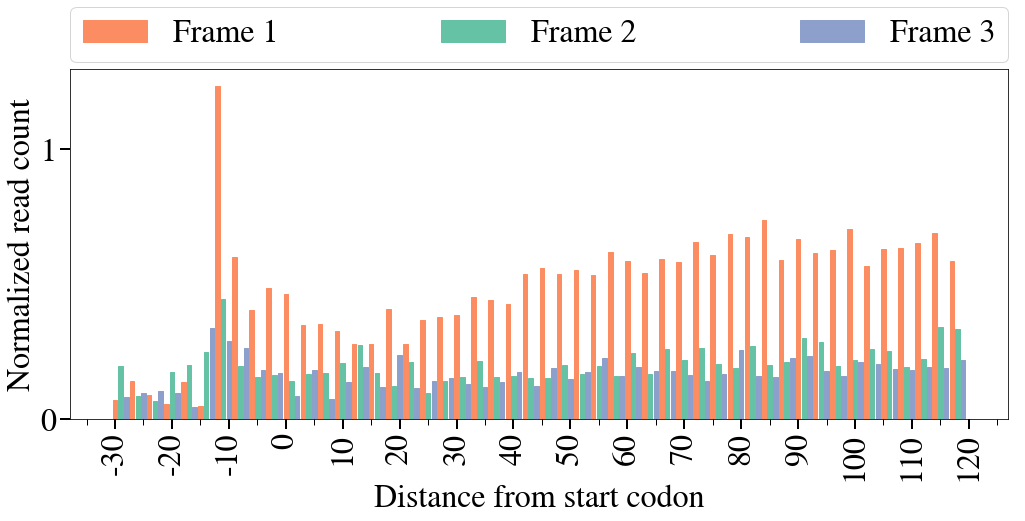

In [38]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_framewise_counts(pd.Series(ribo_counts)[np.arange(-30, 120)], ax=ax)
ax.set_ylabel('Normalized read count')
ax.set_xlabel('Distance from start codon')
fig.tight_layout()
fig.savefig('./plots/idea_ribo_SRX2536403_periodicity.svg')

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


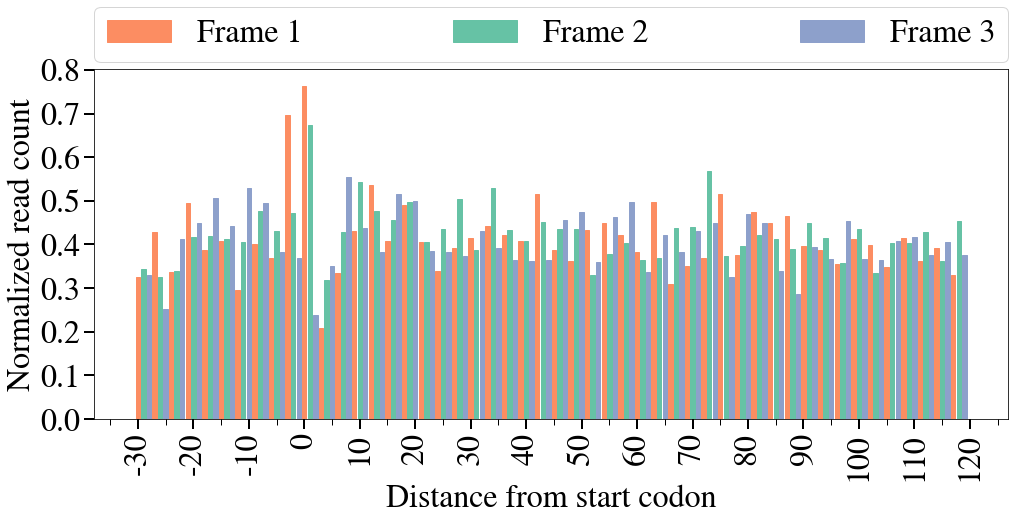

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_framewise_counts(pd.Series(rna_counts)[np.arange(-30, 120)], ax=ax)
ax.set_ylabel('Normalized read count')
ax.set_xlabel('Distance from start codon')
fig.tight_layout()
fig.savefig('./plots/idea_rna_SRX2536425_periodicity.svg')

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


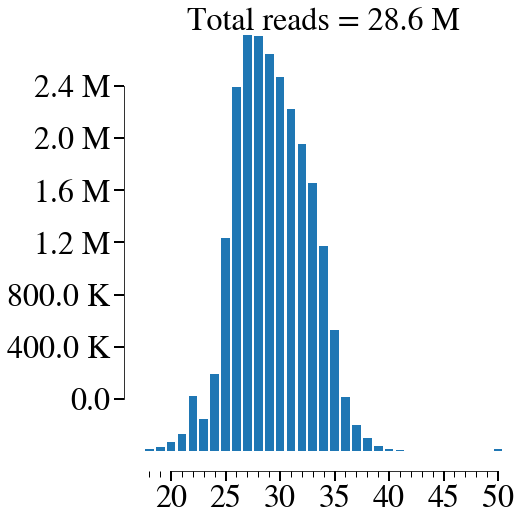

In [30]:
rna_sample_read_len = pd.read_table('/data1/hg38/SRP098789/read_lengths/SRX2536425.tsv')
fig, ax = plt.subplots(figsize=(8, 8))
plot_read_length_dist(pd.Series(rna_sample_read_len['count'].values.tolist(),
                                index=rna_sample_read_len.read_length.values.tolist()),
                     ax=ax)
fig.tight_layout()
fig.savefig('./plots/idea_rna_SRX2536425.svg')


In [63]:
counts_ribo = ribo_counts[np.arange(0,12)]
#fig, ax = plt.subplots(figsize=(18, 8))
#plot_framewise_counts(counts_ribo, ax=ax, majorticks=1)

In [64]:
len(counts_ribo)

12

In [65]:
counts_normalized_ribo = []
for index in np.arange(0, len(counts_ribo), 3):
    counts_normalized_ribo.append(counts_ribo[index]/counts_ribo[index])
    counts_normalized_ribo.append(counts_ribo[index+1]/counts_ribo[index])
    counts_normalized_ribo.append(counts_ribo[index+2]/counts_ribo[index])

In [66]:
coherence(counts_normalized_ribo,3,0)[0]

TypeError: coherence() takes from 1 to 2 positional arguments but 3 were given

In [82]:
coherence(counts_normalized_ribo,30,0)[0]

0.9788160059651421

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


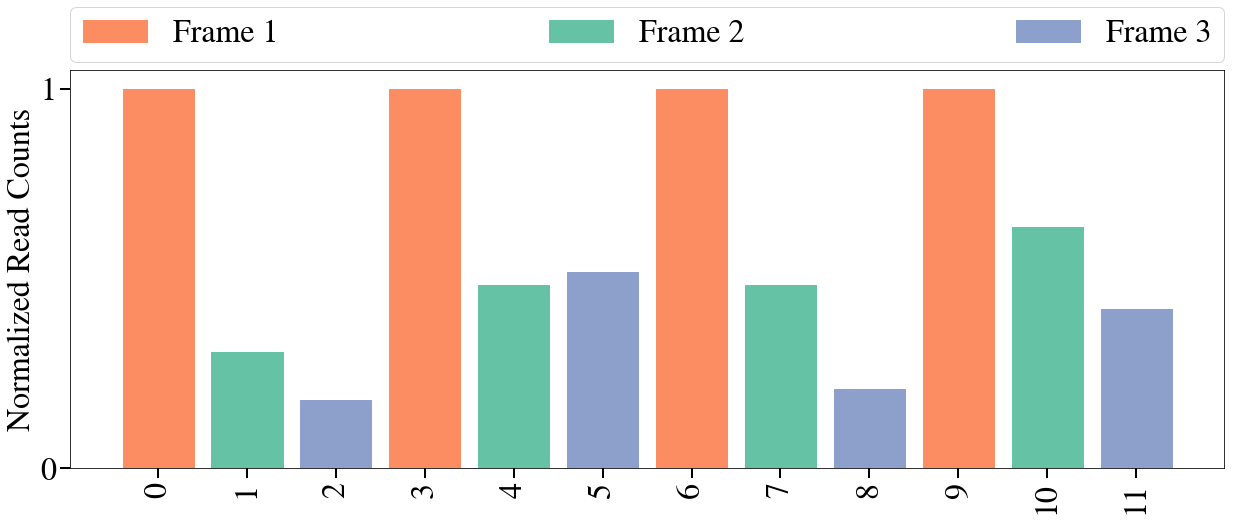

In [67]:
fig, ax = plt.subplots(figsize=(18, 8))
plot_framewise_counts(pd.Series(counts_normalized_ribo), ax=ax, majorticks=1, xrotation=90)

ax.set_ylabel('Normalized Read Counts')
fig.tight_layout()
fig.savefig('./plots/ribo_metagene_normalized.svg')


/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


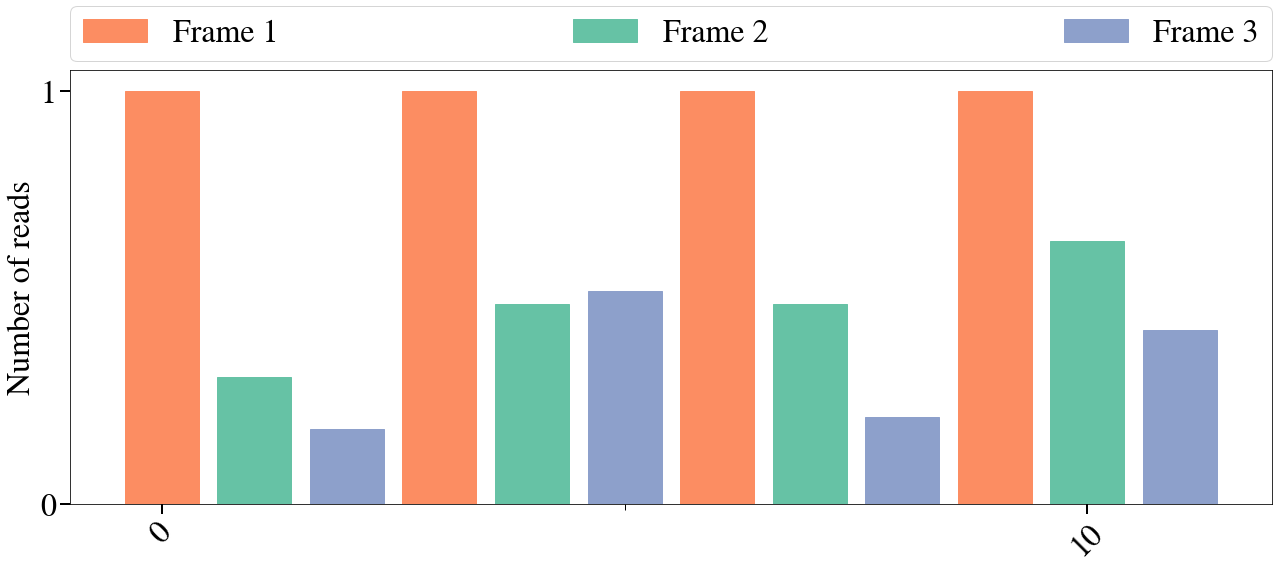

In [43]:
fig, ax = plt.subplots(figsize=(18, 8))
plot_framewise_counts(pd.Series(counts_normalized_ribo), ax=ax)

In [61]:
counts_normalized_ribo

[1.0,
 0.3074416899130405,
 0.18048514344090838,
 1.0,
 0.4832879492529838,
 0.5163496175395195,
 1.0,
 0.48403588811687737,
 0.2104445165605587,
 1.0,
 0.635253677877567,
 0.42117615305298345]

In [46]:
coherence(counts_normalized_ribo,3,0)[0]

0.8270973437330257

[1.0, 0.3074416899130405, 0.18048514344090838, 1.0, 0.4832879492529838, 0.5163496175395195, 1.0, 0.48403588811687737, 0.2104445165605587, 1.0, 0.635253677877567, 0.42117615305298345, 1.0, 0.9894789797121557, 0.6972462853759237, 1.0, 0.6175839696374531, 0.4303495805972122, 1.0, 0.2980944265081081, 0.5761036102148598, 1.0, 0.7556711487306443, 0.4173302385323272, 1.0, 0.25814920363694727, 0.38299574272059683, 1.0, 0.37019703040008456, 0.4060813833209259, 1.0, 0.4034668491715352, 0.340948587965307, 1.0, 0.4760016482314888, 0.25993353118055973, 1.0, 0.3515310432504731, 0.31059417836109565, 1.0, 0.37056638000266456, 0.4098153416010736, 1.0, 0.28383393099545756, 0.22868034756229388, 1.0, 0.2748262751984565, 0.3379055118978756, 1.0, 0.3725042583409771, 0.2776281658077035, 1.0, 0.30391940802431844, 0.3156463639760509, 1.0, 0.36621887941383624, 0.42024803503243185, 1.0, 0.2558591172902274, 0.25845372463889504, 1.0, 0.415797604351254, 0.3293668496820996, 1.0, 0.30882886718641617, 0.32995676440054

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


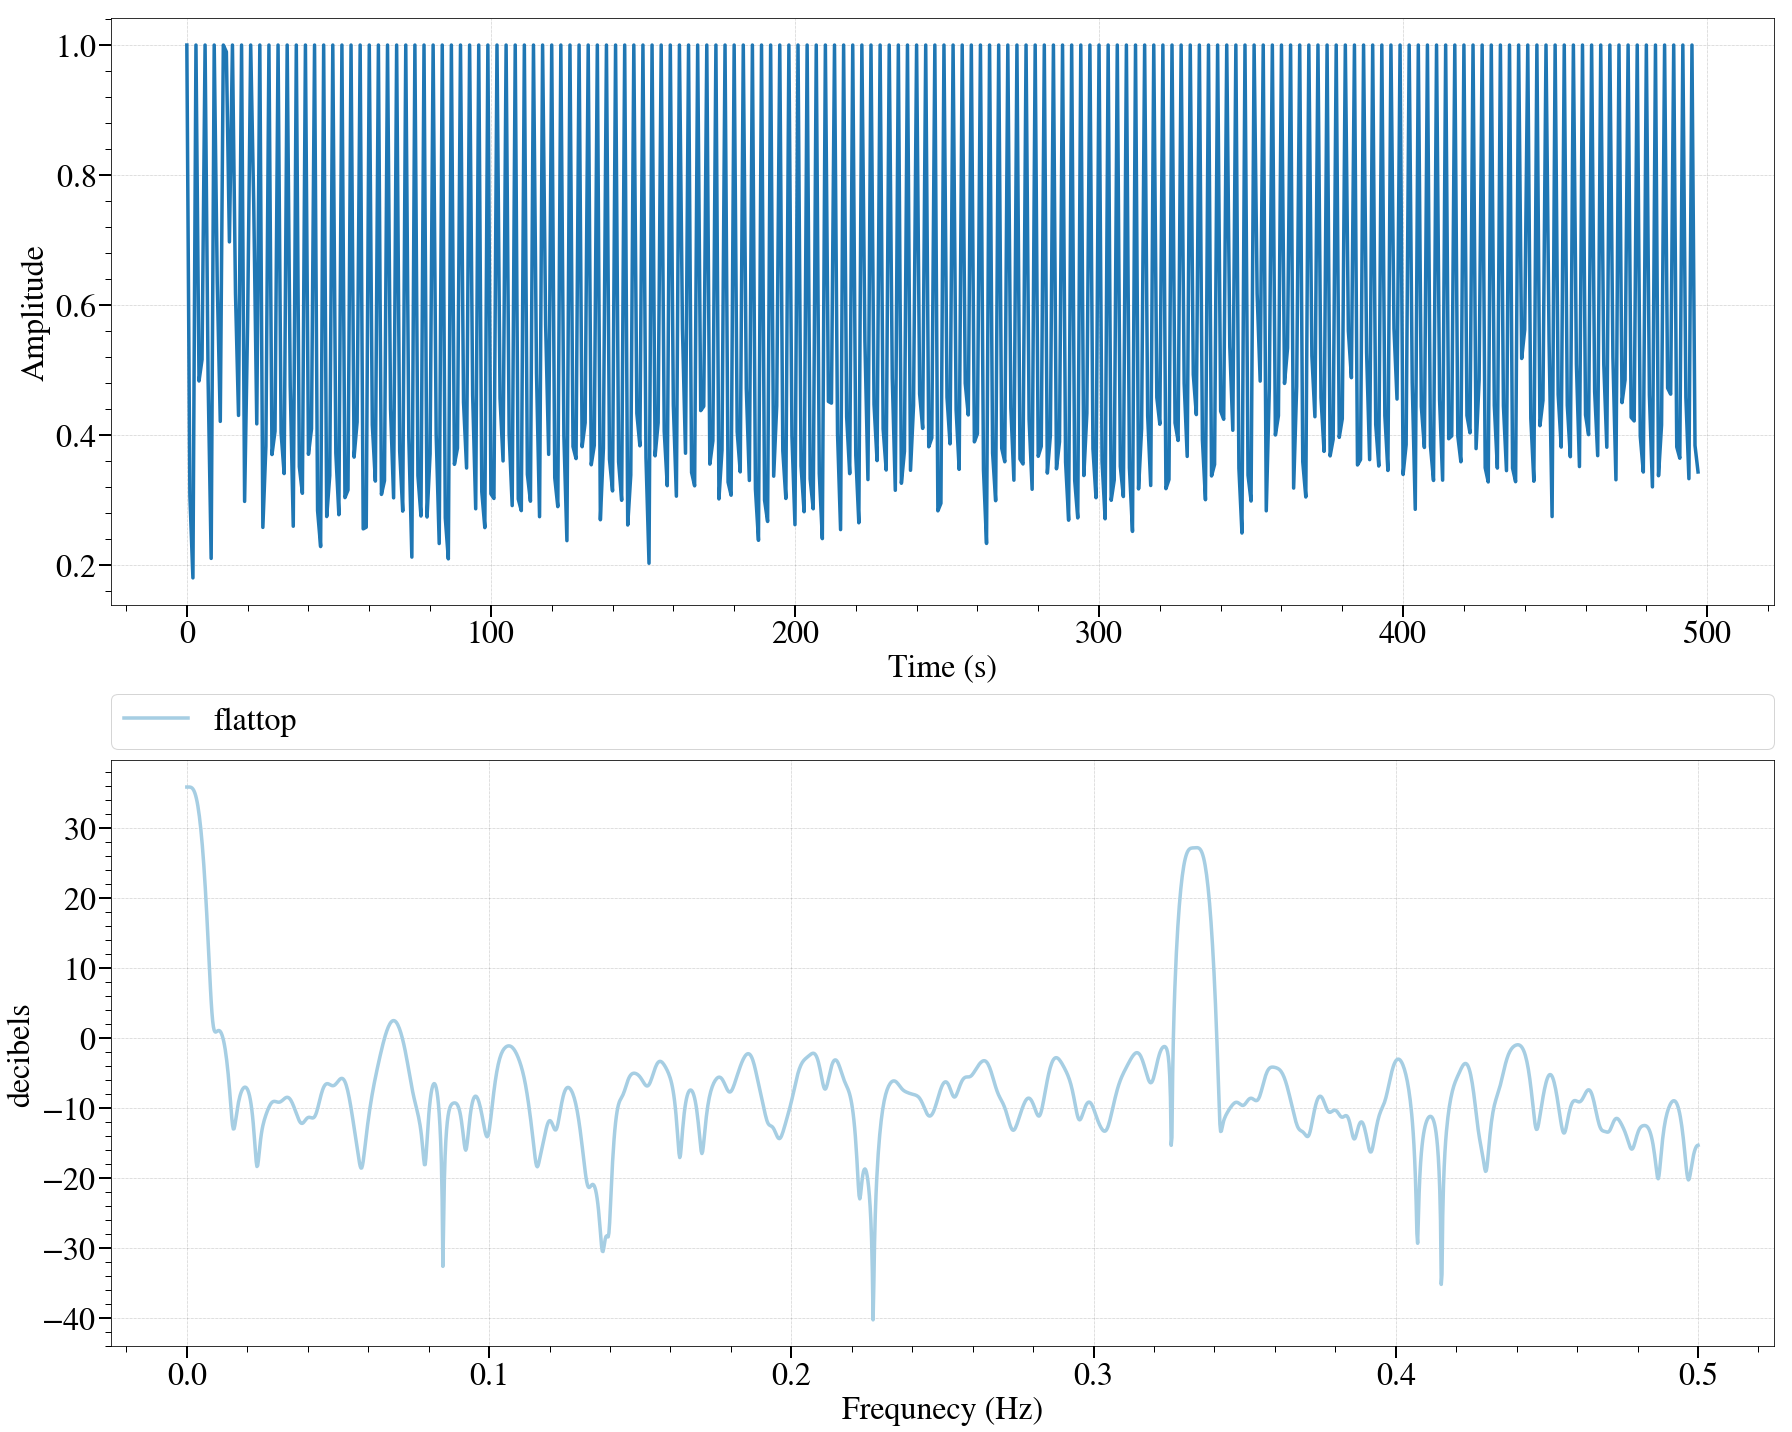

In [83]:
plot_ft(counts_normalized_ribo,   windows='flattop')

In [47]:
coherence(counts_normalized_ribo,3,1)[0]

0.8941978307874437

In [48]:
coherence(counts_normalized_ribo,3,2)[0]

0.8946003688373307

In [49]:
coherence_nonorm(counts_normalized_ribo,3,0)[0]

0.8270973437330258

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


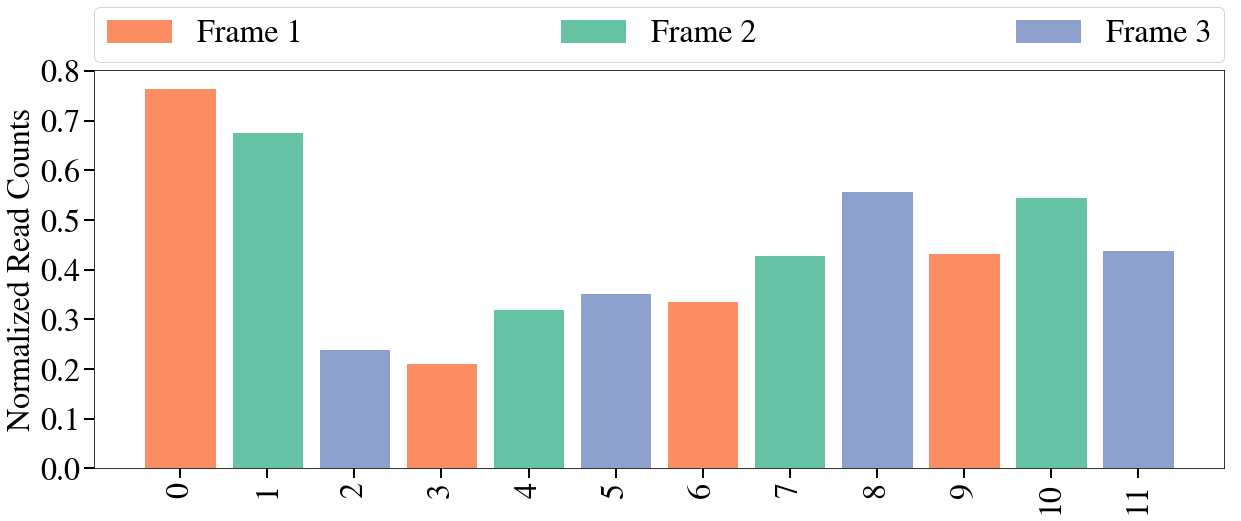

In [53]:
counts_rna = rna_counts[np.arange(0,12)]
fig, ax = plt.subplots(figsize=(18, 8))
plot_framewise_counts(counts_rna, ax=ax, majorticks=1, xrotation=90)

ax.set_ylabel('Normalized Read Counts')
fig.tight_layout()
fig.savefig('./plots/rna_metagene_normalized.svg')


In [55]:
counts_normalized_rna = []
for index in np.arange(0, len(counts_rna), 3):
    counts_normalized_rna.append(counts_rna[index]/counts_rna[index])
    counts_normalized_rna.append(counts_rna[index+1]/counts_rna[index])
    counts_normalized_rna.append(counts_rna[index+2]/counts_rna[index])

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


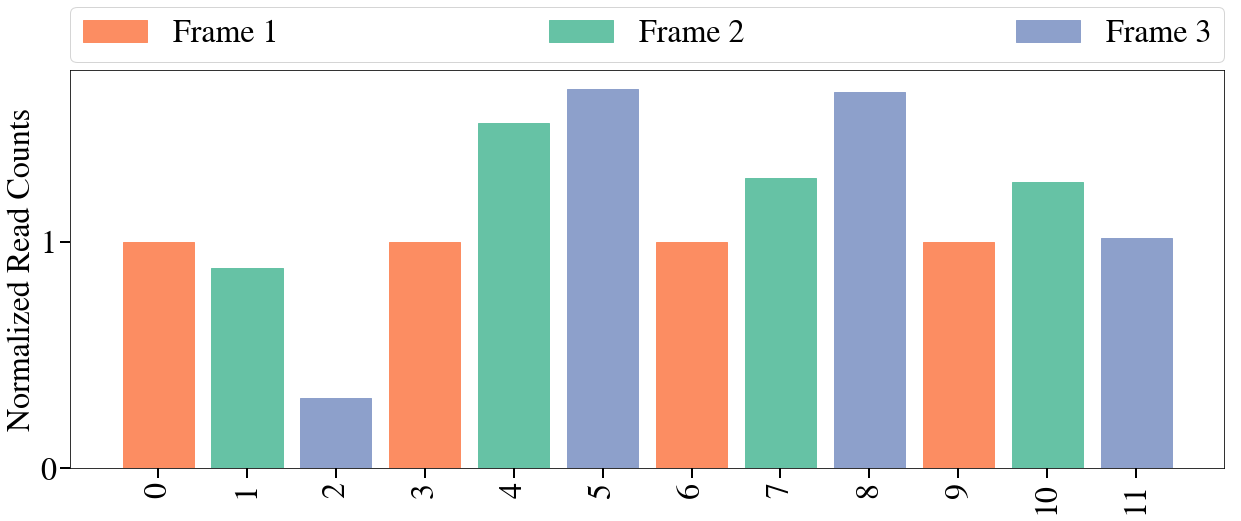

In [57]:
counts_rna = rna_counts[np.arange(0,12)]
fig, ax = plt.subplots(figsize=(18, 8))
plot_framewise_counts(pd.Series(counts_normalized_rna), ax=ax, majorticks=1, xrotation=90)

ax.set_ylabel('Normalized Read Counts')
fig.tight_layout()
fig.savefig('./plots/rna_metagene_normalized.svg')


In [ ]:
counts_rna = rna_counts[np.arange(0,12)]
fig, ax = plt.subplots(figsize=(18, 8))
plot_framewise_counts(pd.Series(counts_normalized_rna), ax=ax, majorticks=1, xrotation=90)

ax.set_ylabel('Normalized Read Counts')
fig.tight_layout()
fig.savefig('./plots/rna_metagene_normalized.svg')


In [68]:
counts_normalized_rna

[1.0,
 0.883178942165668,
 0.31078401931276073,
 1.0,
 1.5258566815996177,
 1.6743663937195934,
 1.0,
 1.2802576585170549,
 1.660071269742901,
 1.0,
 1.2630801456650622,
 1.014349675385495]

In [72]:
coherence(counts_normalized_rna[0:3],3,0)[0]

0.9999999999999994

In [58]:
coherence(counts_normalized_rna,3,1)[0]

0.43416187615735

In [60]:
coherence(counts_normalized_rna,3,2)[0]

0.19537560638900522

In [ ]:
coherence(counts,3,1)[0]

In [ ]:
fig, ax = plt.subplots(figsize=(18, 8))

plot_framewise_counts(pd.Series(counts_normalized), ax=ax)

In [46]:
def coherence3_test(original_values):
    """Calculate coherence and an idea ribo-seq signal
    Parameters
    ----------
    values : array like
             List of values
    Returns
    -------
    periodicity : float
                  Periodicity score calculated as
                  coherence between input and idea 1-0-0 signal
    f: array like
       List of frequencies
    Cxy: array like
         List of coherence at the above frequencies
    """
    p, valid = 0.0, -1
    for frame in [0, 1, 2]:
        values = original_values[frame:]
        normalized_values = []
        i = 0
        while i + 2 < len(values):
            if values[i] == values[i+1] == values[i+2] == 0:
                i += 3
                continue
            if values[i] == 0:
                normalized_values += [values[i], values[i+1], values[i+2]]
            else:
                normalized_values += [1.0, values[i+1] / values[i], values[i+2] / values[i]]
            i += 3

        length = len(normalized_values) // 3 * 3
        if length == 0:
            return (0.0, 0)
        normalized_values = normalized_values[:length]
        uniform_signal = [1, 0, 0] * (len(normalized_values) // 3)
        f, Cxy = signal.coherence(
            normalized_values, uniform_signal, window='flattop', nperseg=3, noverlap=0)
        try:
            periodicity_score = Cxy[np.argwhere(np.isclose(f, 1 / 3.0))[0]][0]
        except:
            periodicity_score = 0.0
        if periodicity_score > p:
            p = periodicity_score
            valid = length
        if valid == -1:
            valid = length
    return p, valid

In [50]:
metagene_all = pd.read_table('/data1/SC5314/Kadosh_Flu_Film_Planktonic/metagene_coverages/biofilm-ribo-1.tsv')

metagene_all_counts = pd.Series(metagene_all['count'].tolist(), index=metagene_all['position'].tolist())

metagene_28 = pd.read_table('/data1/SC5314/Kadosh_Flu_Film_Planktonic/metagene_coverage_lengthwise/biofilm-ribo-1/28/5prime_combined.tsv')

metagene_28_counts = pd.Series(metagene_28['count'].tolist(), index=metagene_28['position'].tolist())


/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


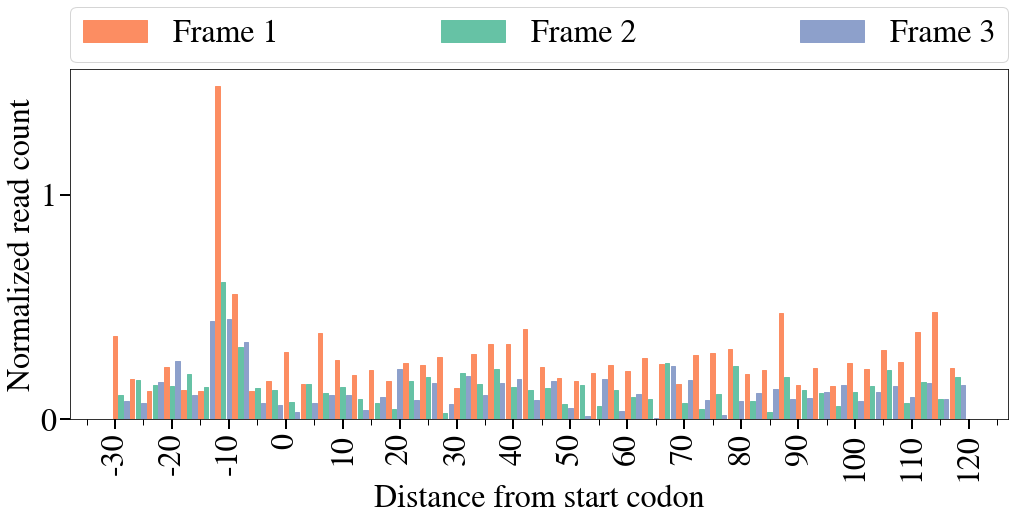

In [45]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_framewise_counts(pd.Series(metagene_all_counts)[np.arange(-30, 120)], ax=ax)
ax.set_ylabel('Normalized read count')
ax.set_xlabel('Distance from start codon')
fig.tight_layout()

fig.savefig('./plots/nonideal_ribo_all_kadosh_periodicity.svg')

In [48]:
coherence3_test(metagene_all_counts[np.arange(-30, 120)].values.tolist())

(0.3691560744657576, 147)

/home/saket/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


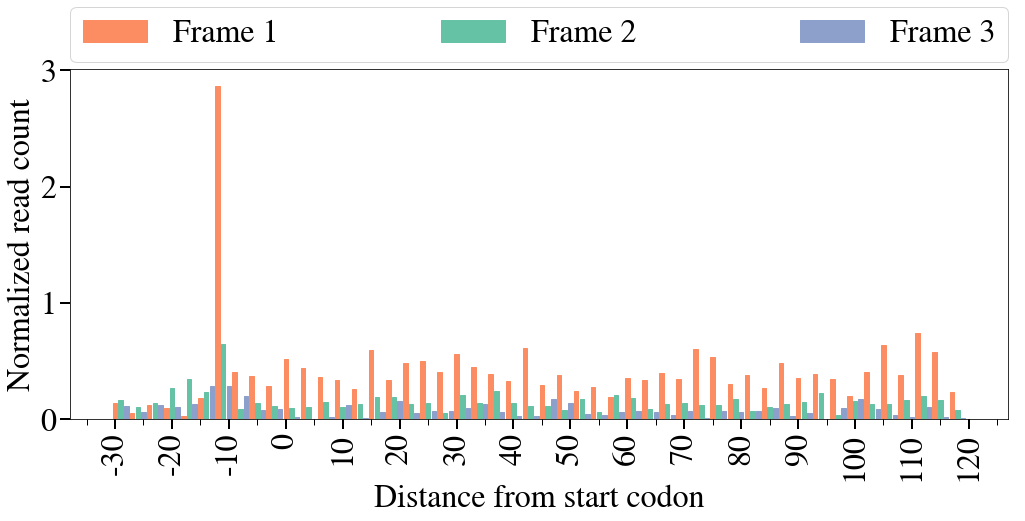

In [51]:
fig, ax = plt.subplots(figsize=(15, 8))

plot_framewise_counts(pd.Series(metagene_28_counts)[np.arange(-30, 120)], ax=ax)
ax.set_ylabel('Normalized read count')
ax.set_xlabel('Distance from start codon')
fig.tight_layout()

fig.savefig('./plots/nonideal_ribo_28_kadosh_periodicity.svg')

In [52]:
coherence3_test(metagene_28_counts[np.arange(-30, 120)].values.tolist())

(0.5895967708356075, 147)